<a href="https://colab.research.google.com/github/cselmo/ECI23-3D/blob/main/Ejercicio_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio 4: Optimización + Redes neuronales

**Ejercicio:**
Modificar el código del ejercicio 3 para que la optimización de la etapa 2 se inicialice con el resultado de la red neuronal MICA:
https://zielon.github.io/mica/

*Hint: ver función ```demo.py``` en el repositorio de MICA para ver un ejemplo de cómo utilizar el modelo.*

**Preguntas:**

- Qué ventajas tiene utilizar una red neuronal como inicialización? Mostrar 3 ejemplos de imágenes concretas que demuestren estas ventajas.

**La ventaja es que la optimización se hace mucho más rápido. Se bajó la cantidad de iteracionse de 10000 a 1000 en la ETAPA 2 y se obtiene una buena cara.**

**Se muestran ejemplos al final de la notebook**

Notas:
- El script de instalación de MICA baja automáticamente el modelo de FLAME (```generic_model.pkl```). Pide usuario y contraseña (pero **la contraseña no está encriptada**).
- Utilizar los keypoints de la base de datos propia (no la de MICA) - los keypoints estimados en el código de MICA son sólo cinco.


## Instalar MICA

In [1]:
device='cuda:0'
#device = 'cpu'

In [2]:
!git clone https://github.com/Zielon/MICA.git

Cloning into 'MICA'...
remote: Enumerating objects: 250, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 250 (delta 84), reused 59 (delta 59), pack-reused 125
Receiving objects: 100% (250/250), 23.49 MiB | 16.43 MiB/s, done.
Resolving deltas: 100% (116/116), done.


In [3]:
%cd /content/MICA
!./install.sh
%cd /content

/content/MICA

If you do not have an account you can register at https://flame.is.tue.mpg.de/ following the installation instruction.
Username (FLAME):carlos.selmo@gmail.com
Password (FLAME):YaVNAj7KBDZm34

--2023-08-15 00:05:01--  https://download.is.tue.mpg.de/download.php?domain=flame&sfile=FLAME2020.zip&resume=1
Resolving download.is.tue.mpg.de (download.is.tue.mpg.de)... 192.124.27.139
Connecting to download.is.tue.mpg.de (download.is.tue.mpg.de)|192.124.27.139|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: download.php?domain=flame&sfile=FLAME2020.zip&resume=1 [following]
--2023-08-15 00:05:02--  https://download.is.tue.mpg.de/download.php?domain=flame&sfile=FLAME2020.zip&resume=1
Reusing existing connection to download.is.tue.mpg.de:443.
HTTP request sent, awaiting response... 200 OK
Length: 153808252 (147M) [application/octet-stream]
Saving to: ‘./FLAME2020.zip’

./FLAME2020.zip     100%[===================>] 146.68M  17.9MB/s    in 9.3s    

202

In [4]:
!pip install yacs
!pip install loguru
!pip install trimesh
!pip install chumpy
!pip install face_alignment
!pip install insightface
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.3/686.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chumpy: filename=chumpy-0.70-py3-none-any.whl size=58264 sha256=7106413ffbe331d710a439a744aadb664f8599693ec03d0ca792a570c661ee7f
  Stored in directory: /root/.cache/pip/wheels/e0/c1/ef/29ba7be03653a29ef6f2c3e1956d6c4d8877f2b243af411db1
Successfully built chumpy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 7.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 85.9 MB/s eta 0:00:00
  Created wheel for insightface: filename=insightface-0.7.3-cp310-cp310-linux_x86_64.whl size=10

In [51]:
import sys
sys.path.append('MICA')

import cv2
from MICA.utils import util
from MICA.configs.config import get_cfg_defaults
from insightface.app.common import Face
from MICA.datasets.creation.util import get_arcface_input, get_center, draw_on
from MICA.utils.landmark_detector import LandmarksDetector, detectors
from skimage.io import imread
import trimesh
import torch
import torch.nn as nn
import numpy as np

In [52]:
cfg =get_cfg_defaults()
cfg.model.testing = True

mica = util.find_model_using_name(model_dir='micalib.models', model_name=cfg.model.name)(cfg, device)
mica.eval()

2023-08-15 00:59:38.433 | INFO     | models.flame:__init__:54 - [FLAME] creating the FLAME Decoder
2023-08-15 00:59:39.468 | INFO     | models.flame:__init__:54 - [FLAME] creating the FLAME Decoder
2023-08-15 00:59:39.589 | INFO     | micalib.models.mica:load_model:52 - [MICA] Trained model found. Path: /content/MICA/data/pretrained/mica.tar | GPU: cuda:0


MICA(
  (masking): Masking()
  (flame): FLAME()
  (arcface): Arcface(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=64)
    (layer1): Sequential(
      (0): IBasicBlock(
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (prelu): PReLU(num_parameters=64)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (downsample): Sequential(
          (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(64, ep

## Instalar FLAME (Ejercicio 3)

In [7]:
!git clone https://github.com/vabrevaya/FLAME

Cloning into 'FLAME'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 23 (delta 10), reused 18 (delta 5), pack-reused 0
Receiving objects: 100% (23/23), 22.64 KiB | 22.64 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [53]:
from FLAME.model import FLAME
from FLAME.util import dict2obj, crop


In [11]:
# bajar imágenes
import gdown
gdown.download("https://drive.google.com/uc?id=1pV8bRp4i277zLzSZ8LutMHWnISYRKkC6", "FFHQ.zip", quiet=False)
! unzip -d data FFHQ.zip

Downloading...
From: https://drive.google.com/uc?id=1pV8bRp4i277zLzSZ8LutMHWnISYRKkC6
To: /content/FFHQ.zip
100%|██████████| 1.22M/1.22M [00:00<00:00, 93.5MB/s]


Archive:  FFHQ.zip
replace data/FFHQ/00000.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Funciones auxiliares

In [54]:
from matplotlib import pyplot as plt
import trimesh
from FLAME.util import cv2_plot_annotations

def load_image(imgpath):
  img = cv2.imread(imgpath)
  img = img[:, :, [2, 1, 0]]
  img = img.astype(np.float32) / 255.
  return img

def project(X, camera):
    """
      X :     vertices a projectar (torch.Tensor size Nx3)
      camera: torch.Tensor de tamaño 3. La primera componente es la escala,
              las últimas dos representación la traslación en la imágen.
    """
    camera = camera.clone().view(-1, 1, 3)
    # translate
    X_trans = X[:, :, :2] + camera[:, :, 1:]
    # scale (torch.mul so that it works on batches)
    Xn = torch.mul(camera[:, :, 0:1], X_trans)
    Xn[..., 1:] = -Xn[..., 1:]

    return Xn
# imagen con keypoints
def plot(img, kpt):
  k = kpt.detach().cpu().numpy()
  k  = (k+1) / 2
  k[..., 0] *= img.shape[1]
  k[..., 1] *= img.shape[0]

  img2 = cv2_plot_annotations(img, k, point_rad=2)
  plt.imshow(img2)
  plt.axis("off")
  plt.show()

def render(mesh, title =""):
    fig = plt.figure(figsize=[6,6])
    vertices = mesh.vertices
    faces = mesh.faces
    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.view_init(elev=90, azim=-90, roll=0)
    ax.plot_trisurf(
        vertices[:, 0],
        vertices[:,1],
        Z = vertices[:,2],
        triangles=faces)
    ax.grid(False)
    ax.set_title(title)
    ax.set_aspect('equal')
    plt.axis('off')
    plt.show()
# funciones de costo
def keypoint_loss(predicted, gt):
  loss = nn.MSELoss()
  return loss(predicted, gt)

def regularizacion(values):
  return values.pow(2.0).sum()

## Cargar imágen y estimar arcface



In [155]:
image_path = '/content/data/FFHQ/00005.png'
img_arcface = cv2.imread(image_path)

# imagen / keypoints para optimización
gt_kpts = np.load('/content/data/FFHQ/00005.npy').astype(np.float32)
img = img_arcface[:, :, [2, 1, 0]]
img = img.astype(np.float32) / 255.
img, gt_kpts = crop(img, gt_kpts)
print (gt_kpts.shape)

gt_kpts =  torch.Tensor(gt_kpts).unsqueeze(0).to(device)
gt_kpts = gt_kpts[...,:2]

# arcface
app = LandmarksDetector(model=detectors.RETINAFACE)
bboxes, kpss = app.detect(img_arcface)
image = imread(image_path)
image = image / 255.
image = cv2.resize(image, (224, 224)).transpose(2, 0, 1)
image = torch.tensor(image).cuda()[None]

i = get_center(bboxes, img)
det_score = bboxes[i, 4]
kps = None
if kpss is not None:
    kps = kpss[i]
bbox = bboxes[i, 0:4]
face = Face(bbox=bbox, kps=kps, det_score=det_score)
arcface, _ = get_arcface_input(face, img_arcface)
arcface = torch.tensor(arcface).cuda()[None]

image = image.to(device)
arcface = arcface.to(device)

(68, 3)
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/antelopev2/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/antelopev2/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/antelopev2/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}


2023-08-15 01:30:53.120 | INFO     | MICA.utils.landmark_detector:__init__:47 - [DETECTOR] Selected RETINAFACE as landmark detector.


find model: /root/.insightface/models/antelopev2/glintr100.onnx recognition ['None', 3, 112, 112] 127.5 127.5
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/antelopev2/scrfd_10g_bnkps.onnx detection [1, 3, '?', '?'] 127.5 128.0
set det-size: (224, 224)


In [156]:
image.size()

torch.Size([1, 3, 224, 224])

In [157]:
arcface.size()

torch.Size([1, 3, 112, 112])

## Ejercicio: optimización con inicialización usando MICA

In [158]:
# dimensiones
d_pose = 6
d_cam = 3
d_shape = 300
d_exp = 100

# crear FLAME (no olvidar subir generic_model.pkl)
cfg = {
    'flame_model_path':'/content/MICA/data/FLAME2020/generic_model.pkl',
    'n_shape':d_shape,
    'n_exp':d_exp,
    'flame_lmk_embedding_path':'/content/MICA/data/FLAME2020/landmark_embedding.npy'
}

cfg=dict2obj(cfg)
flame = FLAME(cfg).to(device)

In [159]:
faces = mica.flameModel.generator.faces_tensor.cpu()

In [160]:
with torch.no_grad():
    codedict = mica.encode(image, arcface)
    opdict = mica.decode(codedict)
    meshes = opdict['pred_canonical_shape_vertices']
    code = opdict['pred_shape_code']
    lmk = mica.flame.compute_landmarks(meshes)

    mesh = meshes[0]
    landmark_51 = lmk[0, 17:]
    landmark_7 = landmark_51[[19, 22, 25, 28, 16, 31, 37]]

    mesh = trimesh.Trimesh(vertices=mesh.cpu() * 1000.0, faces=faces, process=False)
    mesh.export('mesh.obj')

In [161]:
# === ETAPA 1 ===
# Inicializar parámetros a optimizar: cara media con pose neutra

shape = code
exp = torch.zeros(1, d_exp).float().to(device)
pose = torch.zeros(1, d_pose).float().to(device)
camera = torch.zeros(1,d_cam)
camera[0] = 5.
camera = camera.float().to(device)

# Para que pytorch tome las variables como optimizables
#shape = nn.Parameter(shape).to(device)
#exp = nn.Parameter(exp).to(device)
camera = nn.Parameter(camera).to(device)
pose = nn.Parameter(pose).to(device)

# Lista de parámetros a optimizar
# params = [shape, exp, pose, camera]
params = [pose, camera]

# Optimizador
# Otra opción : torch.optim.SGD (stochastic gradient descent)
opt = torch.optim.Adam(
    params,
    lr=0.1
)

# === Loop de optimización ===
its_etapa1 = 1000
wid_etapa1 = 0.001
wexp_etapa1 = 0.001

from tqdm import tqdm

with tqdm(range(its_etapa1), unit="iteration") as t_it:
  for it in t_it:
    t_it.set_description("Iteración: ")

    # generar instancia
    vs, pred_kpts, _exit_code = flame(shape, exp, pose)

    # proyectar keypoints
    pred_kpts = project(pred_kpts, camera)
    pred_kpts = pred_kpts[:,:,:2]

    # sólo usamos keypoints estáticos
    pred = pred_kpts[:, 17:, :2]
    gt = gt_kpts[:, 17:, :2]

    # función de costo
    lmk_loss = keypoint_loss(pred_kpts, gt_kpts)
    reg_id = regularizacion(shape)
    reg_exp = regularizacion(exp)

    loss = lmk_loss + wid_etapa1*reg_id + wexp_etapa1*reg_exp

    # optimizar
    opt.zero_grad()
    loss.backward(retain_graph=True)
    opt.step()

    # ver progreso
    # print ("iter: %d" % it, "L2 loss: %.4f" % loss)
    t_it.set_postfix(loss=loss.item(), lmk_loss=lmk_loss.item(), reg_id=reg_id.item(), reg_exp=reg_exp.item())



Iteración: : 100%|██████████| 1000/1000 [00:15<00:00, 66.37iteration/s, lmk_loss=0.25, loss=0.345, reg_exp=0, reg_id=95.9]


In [162]:
# === ETAPA 2 ===

# Agregar shape y expresión
shape = nn.Parameter(shape).to(device)
exp = nn.Parameter(exp).to(device)

# Lista de parámetros a optimizar
params = [shape, exp, pose, camera]

# Crear optimizador de vuelta
opt = torch.optim.Adam(
    params,
    lr=0.1
)

# === Loop de optimización ===
its_etapa2 = 1000
wid_etapa2 = 0.00001
wexp_etapa2 = 0.00001

from tqdm import tqdm

with tqdm(range(its_etapa2), unit="iteration") as t_it:
  for it in t_it:
    t_it.set_description("Iteración: ")

    # generar instancia
    vs, pred_kpts, _ = flame(shape, exp, pose)

    # proyectar landmarks
    pred_kpts = project(pred_kpts, camera)
    pred_kpts = pred_kpts[:,:,:2]

    # sólo usamos landmarks estáticas
    pred = pred_kpts[:, 17:, :2]
    gt = gt_kpts[:, 17:, :2]

    # función de costo
    lmk_loss = keypoint_loss(pred_kpts, gt_kpts)
    reg_id = regularizacion(shape)
    reg_exp = regularizacion(exp)

    loss = lmk_loss + wid_etapa2*reg_id + wexp_etapa2*reg_exp

    # optimizar
    opt.zero_grad()
    loss.backward(retain_graph=True)
    opt.step()

    # ver progreso
    t_it.set_postfix(loss=loss.item(), lmk_loss=lmk_loss.item(), reg_id=reg_id.item(), reg_exp=reg_exp.item())

Iteración: : 100%|██████████| 1000/1000 [00:15<00:00, 63.48iteration/s, lmk_loss=0.000769, loss=0.00146, reg_exp=10.9, reg_id=57.8]


In [163]:
# guardar mesh
V,_,_ = flame(shape, exp, pose)
V = V[0].detach().cpu().numpy()
F = flame.faces_tensor.cpu().numpy()
mesh = trimesh.Trimesh(vertices=V, faces=F)
mesh.export('result.obj')
from google.colab import files
files.download('result.obj')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Algunos ejemplos

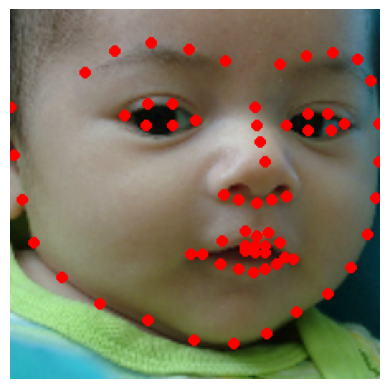

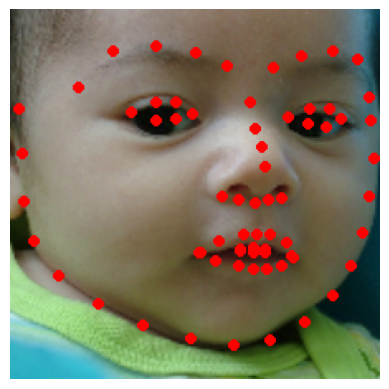

In [142]:
plot(img,gt_kpts)
plot(img,pred_kpts)

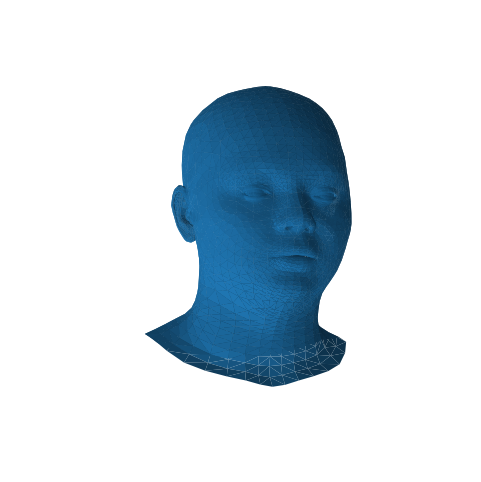

In [143]:
render(mesh)

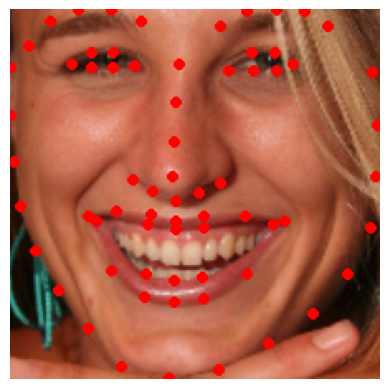

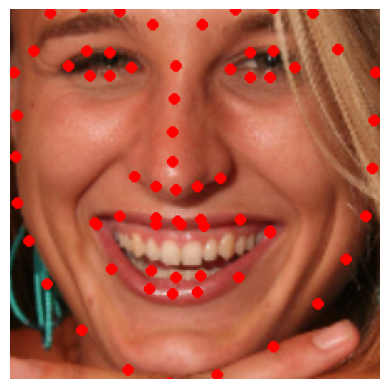

In [131]:
plot(img,gt_kpts)
plot(img,pred_kpts)

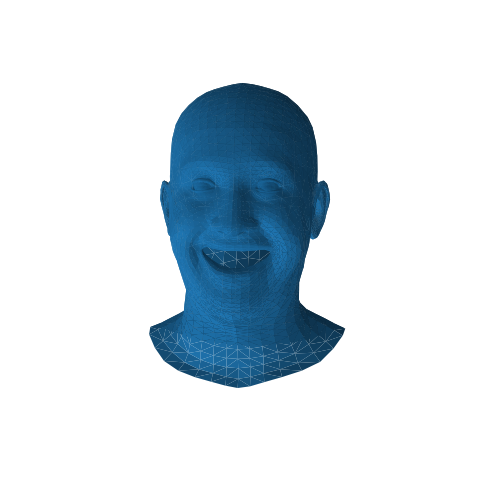

In [132]:
render(mesh)

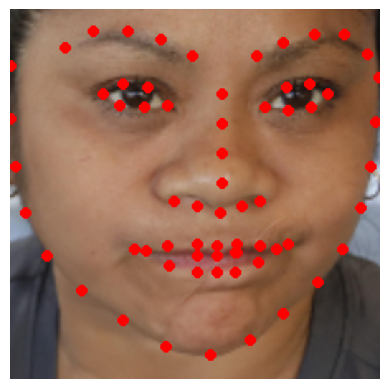

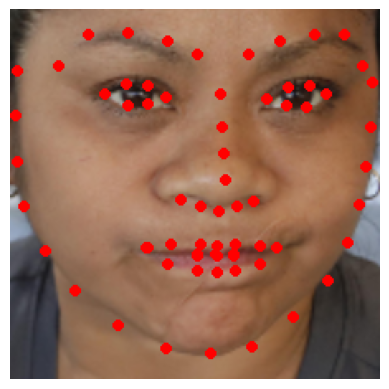

In [153]:
plot(img,gt_kpts)
plot(img,pred_kpts)

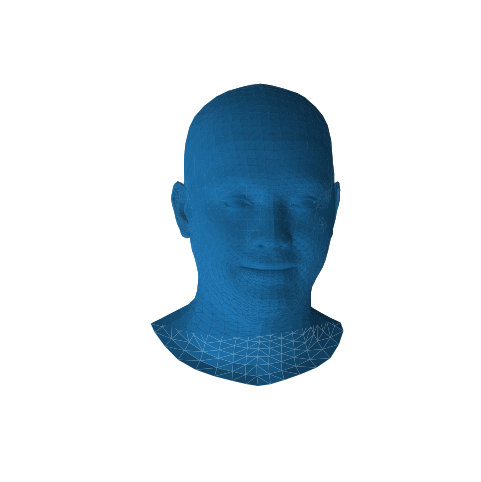

In [154]:
render(mesh)

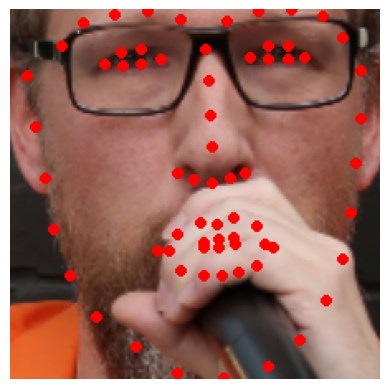

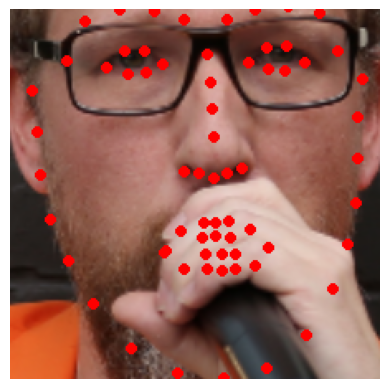

In [164]:
plot(img,gt_kpts)
plot(img,pred_kpts)

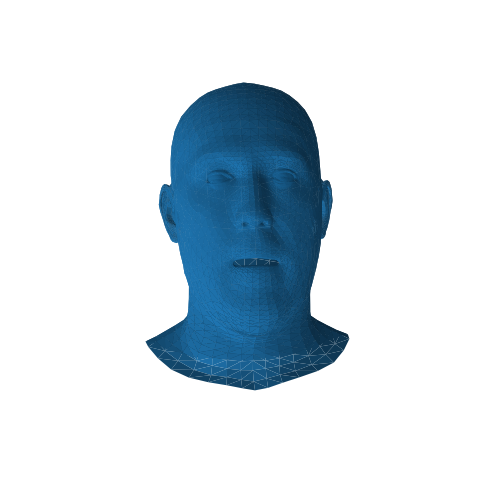

In [165]:
render(mesh)